In [1]:
from multiprocessing import pool
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import dill as pickle
import time
import matplotlib.pyplot as plt
import os
import random
from calendar import monthrange
import bayesnewton
from scipy.cluster.vq import kmeans2
import objax
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon

In [2]:
def load_data(pollutant, data_path="data/", time_step=None, time_range=None, season=None, day_of_week=None, time_of_day=None, noisy=False, decimals=6):
    """
    :param pollutant: {"CO", "NO2", "O3", "SO2", "PM10", "PM25"}
    :param data_path: path to data directory
    :param time_step: if provided, {"H", "D", "M", "Y"}
    :param time_range: if provided, get data within the given time_range, inclusive
            If second element isn't provided, defaults to present day
    :param season: true, false - creates columns for each seasons denoted by binary columns to the season datapoint belongs to
            Winter: December, January, Ferbruary
            Spring: March, April and May
            Summer: June, July and August
            Autumn: September, October and November
    :param day_of_week: true, false
            0 : weekday
            1 : weekend
    :param time_of_day: true, false
            0 : daytime
            1 : nighttime
    """
    df = pd.read_csv(f"{data_path}{pollutant}.csv", parse_dates=["date"])

    df = df.loc[df[pollutant.lower()] > 0]
    # get data within a given time range
    if time_range:
        start, end = time_range
        if not end:
            end = datetime.today
        df = df.loc[(df["date"] >= start) & (df["date"] <= end)]

    df = df.set_index("date")
    # daily, monthly, yearly
    if time_step in {"D", "M", "Y"}:
        index_format = {"D": "%Y-%m-%d", "M": "%Y-%m", "Y": "%Y"}
        df = df.groupby(by=["code"]).resample(time_step).mean().dropna()
        # df["date"] = df["date"].apply(lambda x: x.strftime(index_format[time_step]))

    df = df.reset_index()
    # seasonal buckets
    # creates binary column for each season 
    # (1 represents that the data point is part of that season, 0 represents not part of season)
    if season:
        seasons = {"winter": [12, 1, 2], 
                "spring": [i for i in range(3, 6)], 
                "summer" : [i for i in range(6, 9)], 
                "autumn" : [i for i in range(9, 12)]}

        df["Month"] = pd.DatetimeIndex(df['date']).month
        # print(df)

        # define condition: month must be within seasonal month range
        
        for s in seasons:
            # condition = (df.Month in seasons[season])
            condition = ((df.Month >= seasons[s][0]) & (df.Month <=seasons[s][-1]))
            if s == "winter":
                condition = ((df.Month >= seasons[s][0]) | (df.Month <= seasons[s][-1]))
            df[s] = np.where(condition, 1, 0)

        # drop created month column
        df = df.drop(["Month"], axis=1)
        
    # day of week buckets: weekday vs weekend
    # creates binary column for 'day_of_week' (1 represents weekday, 0 represents weekend)
    if day_of_week:
        weekdays = [i for i in range(5)]
        df["DayOfWeek"] = pd.DatetimeIndex(df['date']).dayofweek
        # condition = (df.DayOfWeek in weekdays)
        condition = ((df.DayOfWeek >= weekdays[0]) & (df.DayOfWeek <= weekdays[-1]))

        # add binary column denoting whether data point belongs to input day of week group
        df['day_of_week'] = np.where(condition, 1, 0)
        df = df.drop(["DayOfWeek"], axis=1)
        
    
    # daytime (7am - 5pm) vs nighttime (5pm - 7am) buckets, according to London's sunrise and sunset times
    # creates binary column for 'time_of_day' (1 represents daytime, 0 represents nighttime)
    if time_of_day:
        daytime_hours = [i for i in range(7, 18)]
        df["Hour"] = pd.DatetimeIndex(df['date']).hour
        # condition = (df.Hour in daytime_hours)

        condition = ((df.Hour >= daytime_hours[0]) & (df.Hour <= daytime_hours[-1]))
        if time_of_day == "night":
            condition = ((df.Hour >= daytime_hours[0]) | (df.Hour <= daytime_hours[-1]))

        df["time_of_day"] = np.where(condition, 1, 0)
        df = df.drop(["Hour"], axis=1)

    # generate time_step (t) column
    df = df.sort_values("date")
    dates = df["date"].values

    t = -1
    current_date = None
    time_steps = []
    for date in dates:
        if date != current_date:
            t += 1
            current_date = date
        time_steps.append(t)
    df["t"] = time_steps
    
    df["latitude"] = df["latitude"].round(decimals)
    df["longitude"] = df["longitude"].round(decimals)
        
    if noisy:
        n = df.shape[0]
        lat_noise, lon_noise = np.random.normal(0,10**(-decimals),n), np.random.normal(0,10**(-decimals),n)
        df["latitude"] = df["latitude"] + lat_noise
        df["longitude"] = df["longitude"] + lon_noise
    
    return df

In [3]:
def split_data(df, test_percent=0.2, validation_sites=[]):
    """
    returns: train_df, test_df, val_df
    """
    val_df = df[df["code"].isin(validation_sites)].copy()
    model_df = df[~df["code"].isin(validation_sites)].copy()
    N, M = model_df.shape
    indices = np.arange(N)
    train_indices, test_indices = train_test_split(indices, test_size=test_percent)
    train_df, test_df = model_df.iloc[train_indices, :].copy(), model_df.iloc[test_indices, :].copy()
    return train_df, test_df, val_df

In [4]:
def scale_data(train_df, test_df, val_df, features):
    scalers = {}
    for feature in features:
        scaler = StandardScaler()
        train_df[f"scaled_{feature}"] = scaler.fit_transform(train_df[[feature]].values)
        test_df[f"scaled_{feature}"] = scaler.transform(test_df[[feature]].values)
        if val_df.shape[0] > 0:
            val_df[f"scaled_{feature}"] = scaler.transform(val_df[[feature]].values)
        scalers[feature] = scaler
    return scalers

In [5]:
def train_model(train_df, x_features, y_features, sparse=True, num_z_space=30):
    X = train_df[x_features].values
    Y = train_df[y_features].values
    t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
    Nt = t.shape[0]
    print("num time steps =", Nt)
    Nr = R.shape[1]
    print("num spatial points =", Nr)
    N = Nt * Nr
    print("num data points =", N)

    var_y = 5.
    var_f = 1.
    len_time = 0.01
    len_space = 0.2

    opt_z = sparse

    if sparse:
        z = kmeans2(R[0, ...], num_z_space, minit="points")[0]
    else:
        z = R[0, ...]

    kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
    kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
    kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
    kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

    kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                    spatial_kernel=kern_space,
                                                    z=z,
                                                    sparse=sparse,
                                                    opt_z=opt_z,
                                                    conditional='Full')

    lik = bayesnewton.likelihoods.Gaussian(variance=var_y)

    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y, parallel=False)

    lr_adam = 0.01
    lr_newton = 1.
    iters = 300
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E

    train_op = objax.Jit(train_op)
    
    t0 = time.time()
    for i in range(1, iters + 1):
        loss = train_op()
        print('iter %2d: energy: %1.4f' % (i, loss[0]))
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    avg_time_taken = (t1-t0)/iters
    print('average iter time: %2.2f secs' % avg_time_taken)

    return model

In [6]:
def test_model(model, test_df, x_features, y_features):
    X_test = test_df[x_features].values
    Y_test = test_df[y_features].values
    t_test, R_test, Y_test = bayesnewton.utils.create_spatiotemporal_grid(X_test, Y_test)

    print(t_test.shape)
    print(R_test.shape)
    print(R_test)

    test_mean, test_var = model.predict_y(X=t_test, R=R_test)
    nlpd = model.negative_log_predictive_density(X=t_test, R=R_test, Y=Y_test)
    rmse = np.sqrt(np.nanmean((np.squeeze(Y_test) - np.squeeze(test_mean))**2))
    print('nlpd: %2.3f' % nlpd)
    print('rmse: %2.3f' % rmse)

    return test_mean, test_var, nlpd, rmse

In [7]:
def save_model(filename, df, model, train_df, test_df, val_df, train_scalers):
    path = f"GPR-models/ST-SVGP/{filename}/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    df_filename = f"{path}{filename}_df.sav"
    model_filename = f"{path}{filename}_model.sav"
    train_df_filename = f"{path}{filename}_train_df.sav"
    test_df_filename = f"{path}{filename}_test_df.sav"
    val_df_filename = f"{path}{filename}_val_df.sav"
    scalers_filename = f"{path}{filename}_scalers.sav"
    pickle.dump(df, open(df_filename, "wb"))
    pickle.dump(model, open(model_filename, "wb"))
    pickle.dump(train_df, open(train_df_filename, "wb"))
    pickle.dump(test_df, open(test_df_filename, "wb"))
    pickle.dump(val_df, open(val_df_filename, "wb"))
    pickle.dump(train_scalers, open(scalers_filename, "wb"))

In [8]:
def load_model(filename):
    path = f"GPR-models/ST-SVGP/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    val_df = pickle.load(open(f"{path}_val_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, val_df, scalers

In [9]:
def plot_site(model, df, code, x_features, y_features, scalers, title="Predictions after training", save=False, save_path="GPR_figures/"):
    min_t, max_t = df["t"].min(), df["t"].max()
    t_plot = np.linspace(min_t, max_t, max_t-min_t+1).reshape(-1, 1)
    start_date, end_date = df["date"].min(), df["date"].max()
    delta = end_date - start_date
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)]
    
    site_lat, site_lon = df.loc[df['code'] == code]['latitude'].unique()[0], df.loc[df['code'] == code]['longitude'].unique()[0]
    scaled_lat = scalers['latitude'].transform(np.array([[site_lat]])).item()
    scaled_lon = scalers['longitude'].transform(np.array([[site_lon]])).item()
    R_plot = np.tile(np.array([[scaled_lat, scaled_lon]]), [t_plot.shape[0], 1, 1])

    plt.figure()
    plt.subplots(facecolor="white", figsize=(24, 12))

    # PLOT PREDICTION WITH VARIANCE
    prediction_mean, prediction_std = model.predict_y(X=t_plot, R=R_plot)
    prediction_mean, prediction_std = prediction_mean.flatten(), prediction_std.flatten()
    (line,) = plt.plot(dates, prediction_mean, lw=1.5, label="Mean of predictive posterior")
    plt.fill_between(
        dates,
        prediction_mean-1.96*prediction_std,
        prediction_mean+1.96*prediction_std,
        color=line.get_color(),
        alpha=0.6,
        label=r"95% confidence interval"
    )
    
    # PLOT ACTUAL VALUES
    Y_dates, Y_true = df["date"], df[y_features]
    plt.plot(Y_dates, Y_true, ".", label="Validation points", alpha=0.9, color="red")

    # GET RMSE
    t_rmse = df["t"].values.reshape(-1, 1)
    R_rmse = np.tile(np.array([[scaled_lat, scaled_lon]]), [t_rmse.shape[0], 1, 1])
    rmse_mean, rmse_std = model.predict_y(X=t_rmse, R=R_rmse)
    rmse_mean, rmse_std = rmse_mean.flatten(), rmse_std.flatten()
    rmse = np.sqrt(np.nanmean((np.squeeze(Y_true) - np.squeeze(rmse_mean))**2))

    plt.title(f"{title} for site {code}\nRMSE: {rmse}")
    plt.xlabel(f"Date")
    plt.ylabel(f"Concentration of NO2 (ug/m3)")
    
    plt.gcf().autofmt_xdate()

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.legend(loc=(1.04,0))

    if save:
        plt.savefig(fname=save_path + "prediction_" + code + ".png")
    plt.show()

In [10]:
def get_sites_coords(df):
    sites_info_df = pd.read_csv("../../data/monitoring_sites.csv")
    
    df_sites = df["code"].unique()
    
    S_df = sites_info_df.loc[sites_info_df['SiteCode'].isin(df_sites)][['SiteCode', 'Latitude', 'Longitude']]
    S_df = S_df.rename(columns={"SiteCode": "code", "Latitude": "latitude", "Longitude": "longitude"})
    
    return S_df

In [11]:
def get_census_data():
    census_df = pd.read_csv("../../data/2011_census_economic_activity.csv", index_col=False)
    census_df = census_df.groupby(["Ward Name", "LA Name"], as_index=False).mean()
    census_df = census_df.rename(columns={"Ward Name": "NAME", "LA Name": "BOROUGH"})
    return census_df
    

In [12]:
def sample_wards(ward_df, scalers, n=5):
    # Credit: https://gis.stackexchange.com/a/294403
    def sample_polygon(polygon):
        points, scaled_points = [], []
        min_lon, min_lat, max_lon, max_lat = polygon.bounds
        count = 0
        while count < n:
            lat, lon = random.uniform(min_lat, max_lat), random.uniform(min_lon, max_lon)
            point = Point(lon, lat)
            p_range = [-0.000001, 0.0, 0.000001]
            poly_point = Polygon([(point.x + lam_lon, point.y + lam_lat) for lam_lon in p_range for lam_lat in p_range])
            if polygon.intersects(poly_point):
                points.append([lat, lon])
                scaled_lat = scalers['latitude'].transform(np.array([[lat]])).item()
                scaled_lon = scalers['longitude'].transform(np.array([[lon]])).item()
                scaled_points.append([scaled_lat, scaled_lon])
                count += 1
        return np.array(points), np.array(scaled_points)
    
    wards = ward_df['geometry'].values
    samples, scaled_samples = [], []

    for ward in wards:
        sample, scaled_sample = sample_polygon(ward)
        samples.append(sample)
        scaled_samples.append(scaled_sample)
    
    new_df = ward_df.copy()
    new_df["samples"] = samples
    new_df["scaled_samples"] = scaled_samples
    return new_df
    
    

In [13]:
"""
SPECIFY DATA PARAMETERS
"""
pollutant = "NO2"
time_step = "D"
time_range = (datetime(2011, 1, 1), datetime(2011, 12, 31))
season = False
day_of_week = False
time_of_day = False
noisy = False
decimals = 6

random_id = random.randint(0, 10000)
filename = figure_title = f"STSVGP_MODEL_{random_id}"
print(filename)

STSVGP_MODEL_7206


In [72]:
alex_data_path = "../../data/"
ana_data_path = "../data-collection/LAQN_API_data/"
df = load_data(pollutant, data_path=alex_data_path, time_step=time_step, time_range=time_range, season=season, day_of_week=day_of_week, time_of_day=time_of_day, noisy=noisy, decimals=decimals)

In [73]:
df.head()

,code,date,nox,no2,latitude,longitude,t
14607,HK6,2011-01-01,125.979467,57.506791,51.526454,-0.084910,0
18872,KC2,2011-01-01,101.209239,54.483442,51.495504,-0.178809,0
18519,KC1,2011-01-01,38.743819,31.946076,51.521047,-0.213492,0
18179,IS6,2011-01-01,32.551769,28.877916,51.557895,-0.106989,0
28799,WA7,2011-01-01,277.631357,126.976950,51.463429,-0.215871,0


In [74]:
validation_sites = ["HK6"]
train_df, test_df, val_df = split_data(df, validation_sites=validation_sites)

In [75]:
scaled_features = ["latitude", "longitude"]
scalers = scale_data(train_df, test_df, val_df, scaled_features)

In [17]:
"""
LOAD MODEL
"""
filename = "STSVGP_MODEL_2936"
model, df, train_df, test_df, val_df, scalers = load_model(filename)
census_plot_df = load_obj(filename, "census_df")


In [18]:
x_features = ["t", "scaled_latitude", "scaled_longitude"]
y_features = ["no2"]

In [95]:
len(train_df["code"].unique())

102

In [78]:
model = train_model(train_df, x_features, y_features, sparse=True, num_z_space=50)

num time steps = 365
num spatial points = 102
num data points = 37230


/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:3939: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


iter  1: energy: 7120053.0080
iter  2: energy: 7045581.9128
iter  3: energy: 6969318.9922
iter  4: energy: 6898236.3322
iter  5: energy: 6828779.6861
iter  6: energy: 6760477.0171
iter  7: energy: 6691025.4261
iter  8: energy: 6623556.6164
iter  9: energy: 6557148.2006
iter 10: energy: 6490661.8986
iter 11: energy: 6423933.7571
iter 12: energy: 6357307.3944
iter 13: energy: 6291005.0284
iter 14: energy: 6224954.6947
iter 15: energy: 6158979.1049
iter 16: energy: 6093022.9876
iter 17: energy: 6027290.9048
iter 18: energy: 5962041.5661
iter 19: energy: 5897333.2161
iter 20: energy: 5833097.9656
iter 21: energy: 5769328.2125
iter 22: energy: 5706038.2416
iter 23: energy: 5643203.1181
iter 24: energy: 5580762.1985
iter 25: energy: 5518694.2663
iter 26: energy: 5457046.5819
iter 27: energy: 5395831.9523
iter 28: energy: 5334980.3437
iter 29: energy: 5274419.1455
iter 30: energy: 5214120.3563
iter 31: energy: 5154101.2557
iter 32: energy: 5094411.2283
iter 33: energy: 5035098.7590
iter 34: e

In [96]:
test_mean, test_var, test_nlpd, test_rmse = test_model(model, test_df, x_features, y_features)

nlpd: 45.583
rmse: 29.346


In [97]:
val_mean, val_var, val_nlpd, val_rmse = test_model(model, val_df, x_features, y_features)

nlpd: 9.745
rmse: 11.995


In [98]:
save_model(filename, df, model, train_df, test_df, val_df, scalers)

# Contour Plots

In [19]:
grid_size = 50
# t_plot = np.linspace(df['t'].min(), df['t'].max(), num=df['t'].max()-df['t'].min()+1).reshape(-1, 1)
lat_min, lat_max = 51.279, 51.7
lon_min, lon_max = -0.533, 0.350

t_plot = np.linspace(0, 9, num=10).reshape(-1, 1)
lat_plot = np.linspace(lat_min, lat_max, num=grid_size).reshape(-1, 1)
lon_plot = np.linspace(lon_min, lon_max, num=grid_size).reshape(-1, 1)
LAT, LON = np.meshgrid(lat_plot, lon_plot)

In [20]:
scaled_lat_plot = scalers['latitude'].transform(lat_plot).flatten()
scaled_lon_plot = scalers['longitude'].transform(lon_plot).flatten()
r1_plot, r2_plot = [], []
for i in range(grid_size):
    for j in range(grid_size):
        r1_plot.append([scaled_lat_plot[i]])
        r2_plot.append([scaled_lon_plot[j]])
r1_plot, r2_plot = np.array(r1_plot), np.array(r2_plot)
R_plot = np.tile(np.hstack((r1_plot, r2_plot)), [t_plot.shape[0], 1, 1])

In [21]:
pred_mean, pred_var = model.predict_y(X=t_plot, R=R_plot)

In [22]:
pred_mean_plot = np.mean(pred_mean, axis=0).reshape(grid_size, grid_size)
pred_var_plot = np.mean(pred_var, axis=0).reshape(grid_size, grid_size)

In [23]:
norm_Z = pred_var_plot/pred_var_plot.max()
inv_norm_Z = 1-norm_Z

In [24]:
map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
# map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp"
map_df = gpd.read_file(map_filepath)
map_df = map_df.to_crs("EPSG:4326")
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-0.33066 51.32901, -0.33057 51.32909..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-0.06399 51.31864, -0.06405 51.31861..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((0.01216 51.29960, 0.01199 51.29979, ..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-0.24454 51.48870, -0.24466 51.48868..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-0.41181 51.53408, -0.41186 51.53413..."


In [25]:
z_opt = model.kernel.z.value
z_lat = scalers['latitude'].inverse_transform(z_opt[:, 0].reshape(-1, 1))
z_lon = scalers['longitude'].inverse_transform(z_opt[:, 1].reshape(-1, 1))

<AxesSubplot:title={'center':'STSVGP Model Prediction Variance Across London (2011)'}>

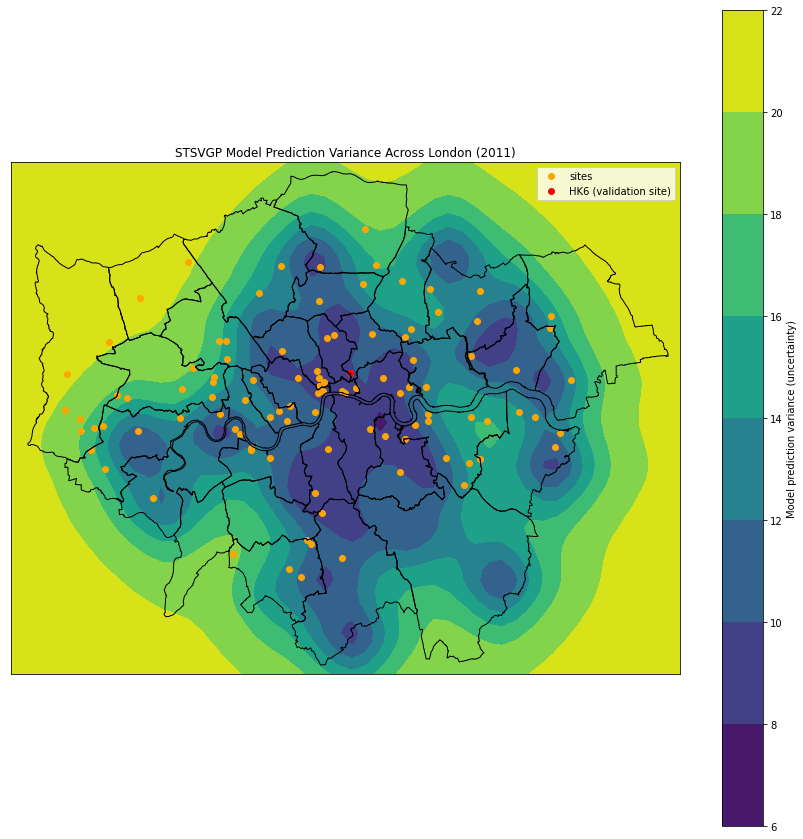

In [33]:
fig, ax = plt.subplots(figsize=(15,15))

plt.title("STSVGP Model Prediction Variance Across London (2011)")
plt.contourf(LON, LAT, pred_var_plot)# norm=normi, extend='both')
plt.colorbar(label="Model prediction variance (uncertainty)")

# plt.imshow(pred_var_plot, extent=[np.asscalar(lon_plot[0]), np.asscalar(lon_plot[-1]), np.asscalar(lat_plot[0]), np.asscalar(lat_plot[-1])], origin="lower")

sites_df = get_sites_coords(df)
plt.scatter(sites_df["longitude"], sites_df["latitude"], label="sites", color="orange")
plt.scatter(sites_df.loc[sites_df['code'] == "HK6", 'longitude'].item(), sites_df.loc[sites_df['code'] == "HK6", 'latitude'].item(), label="HK6 (validation site)", color="red")

#plt.scatter(z_lon, z_lat, label="inducing points", color="purple")
plt.legend()

ax.set_facecolor('white')
ax.axes.xaxis.set_ticklabels([])
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.yaxis.set_ticks([])
map_df.plot(ax=ax, color="None")

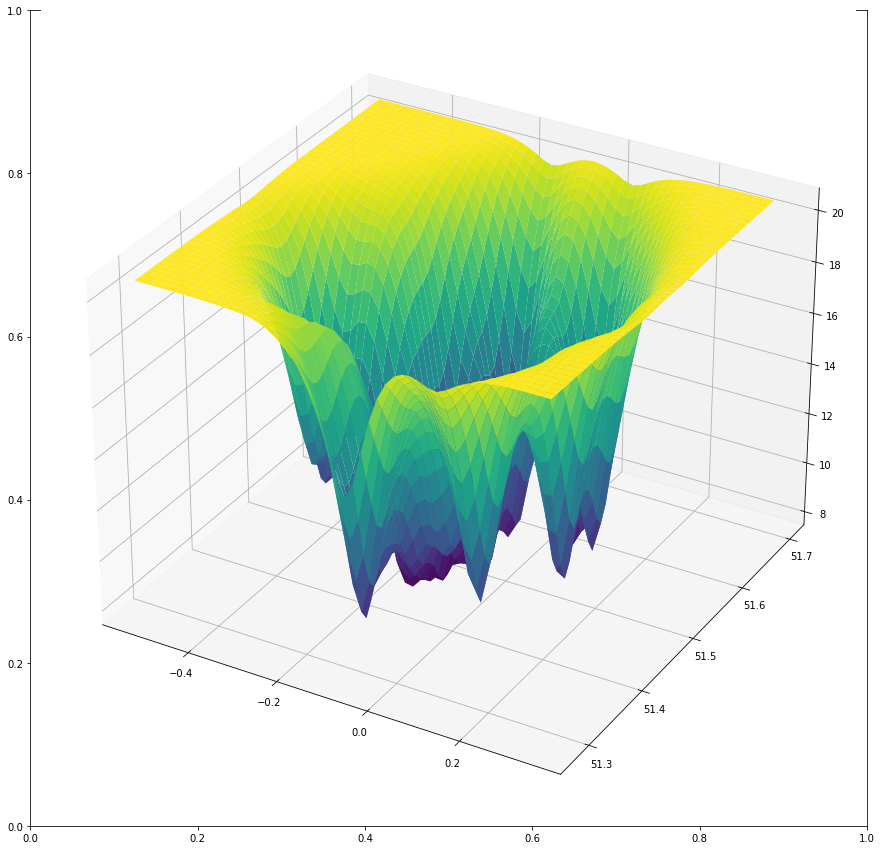

In [29]:
fig, ax = plt.subplots(figsize=(15,15))

ax = plt.axes(projection='3d')
ax.plot_surface(LON, LAT, pred_var_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# Evaluate validation site

<Figure size 432x288 with 0 Axes>

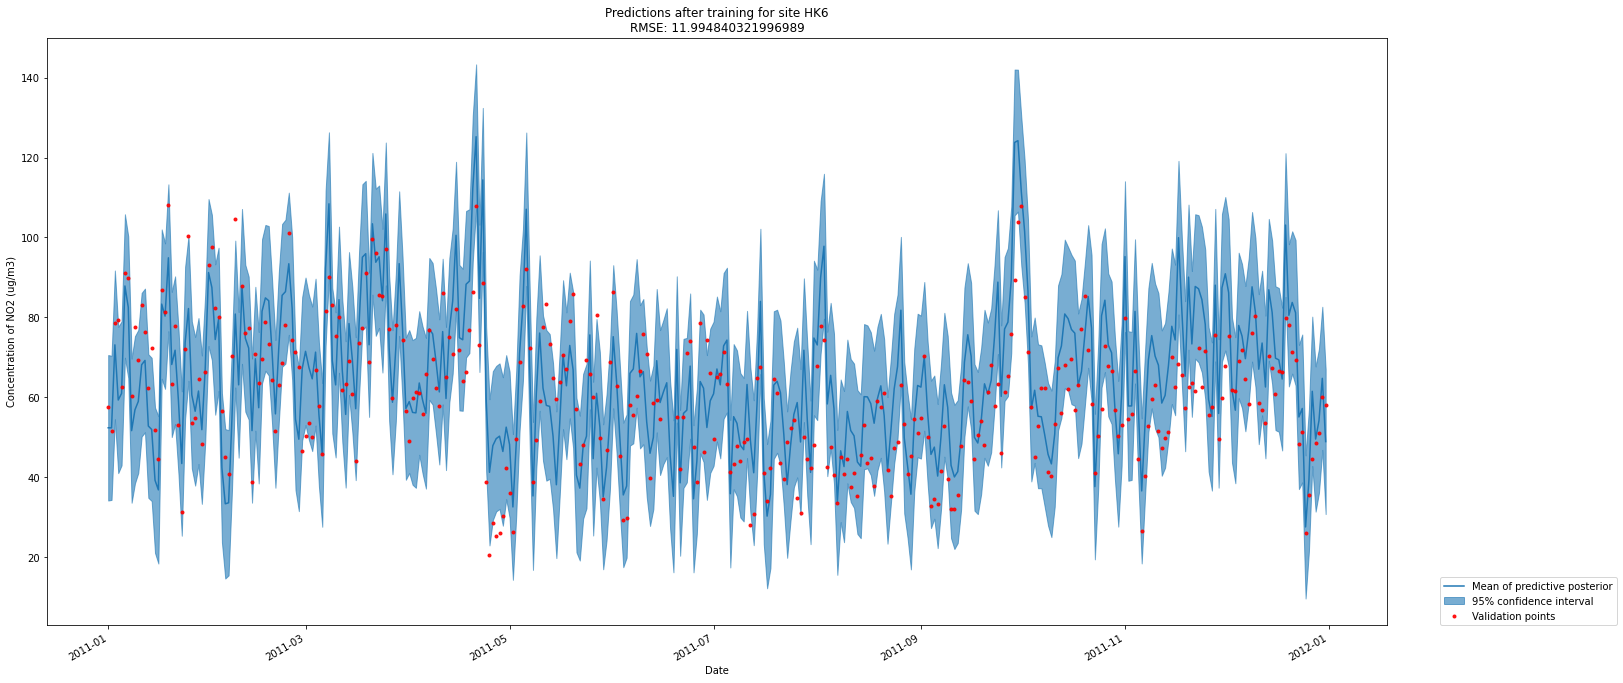

In [41]:
plot_site(model, val_df, "HK6", x_features, y_features, scalers)

# Overlay census data with bivariate map

In [112]:
census_df = get_census_data()

In [113]:
census_map_filepath = "../../data/statistical-gis-boundaries-london/ESRI/London_Ward_CityMerged.shp"
census_map_df = gpd.read_file(census_map_filepath)
census_map_df = census_map_df.to_crs("EPSG:4326")
census_map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33066 51.32901, -0.33057 51.32909..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30843 51.37586, -0.30832 51.37606..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30383 51.39249, -0.30373 51.39252..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26988 51.38845, -0.26973 51.38838..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24660 51.39921, -0.24670 51.39920..."


In [114]:
census_df.head()

,NAME,BOROUGH,QS601EW0002,QS601EW0001 (base),OA Percentage
0,Abbey,Barking and Dagenham,183.400000,268.771429,68.064000
1,Abbey,Merton,185.500000,229.166667,80.711389
2,Abbey Road,Westminster,155.540541,227.864865,67.330541
3,Abbey Wood,Greenwich,154.312500,222.687500,69.068958
4,Abingdon,Kensington and Chelsea,144.243243,214.135135,67.199189


In [115]:
census_plot_df = census_map_df.merge(census_df, on=["NAME", "BOROUGH"])

<AxesSubplot:title={'center':'2011 Air Pollution Sensor Network Uncertainty'}>

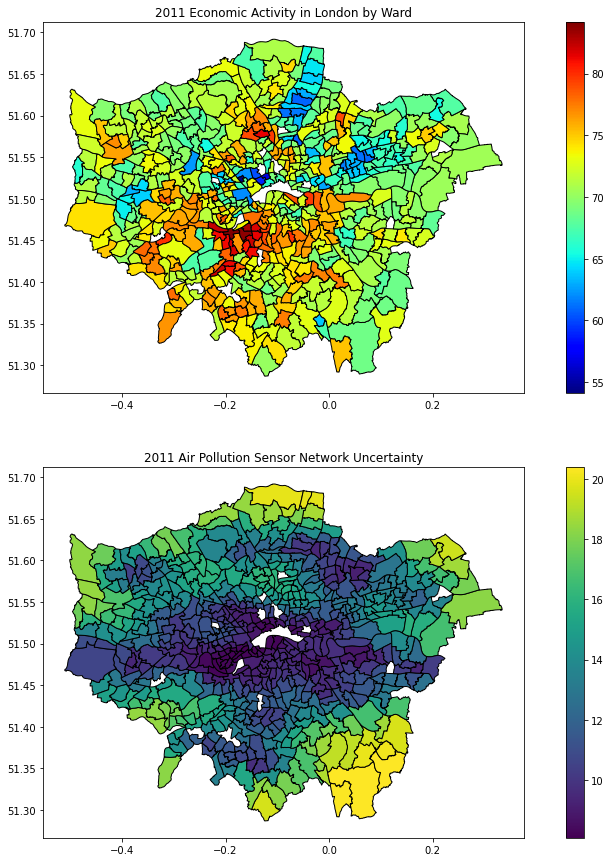

In [31]:
fig, axs = plt.subplots(2, figsize=(15,15))

#norm = plt.Normalize()
#colors = plt.cm.jet(norm(census_plot_df["uncertainty"]))

axs[0].set_facecolor('white')
#census_plot_df.plot(ax=axs[0], color=colors, edgecolor="black")
axs[0].set_title("2011 Economic Activity in London by Ward")
census_plot_df.plot(ax=axs[0], column="OA Percentage", cmap="jet", legend=True, edgecolor="black")

axs[1].set_facecolor('white')
axs[1].set_title("2011 Air Pollution Sensor Network Uncertainty")
census_plot_df.plot(ax=axs[1], column="uncertainty", legend=True, edgecolor="black")

In [117]:
census_plot_df = sample_wards(census_plot_df, scalers)

In [118]:
census_plot_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,QS601EW0002,QS601EW0001 (base),OA Percentage,samples,scaled_samples
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((-0.33066 51.32901, -0.33057 51.32909...",184.548387,240.870968,76.701290,"[[51.354200748188326, -0.31306527254776206], [...","[[-2.6154171535266775, -1.1207259731097525], [..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((-0.30843 51.37586, -0.30832 51.37606...",181.566667,240.533333,75.399333,"[[51.3774894277812, -0.2966613956460623], [51....","[[-2.2083954149464584, -1.0190474100173863], [..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((-0.30383 51.39249, -0.30373 51.39252...",145.444444,197.388889,73.847500,"[[51.386127943342835, -0.29348652028133887], [...","[[-2.057418043789482, -0.999368113042841], [-1..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((-0.26988 51.38845, -0.26973 51.38838...",180.259259,247.185185,72.966296,"[[51.38613581841322, -0.28167693835583874], [5...","[[-2.0572804093294472, -0.9261670442892704], [..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((-0.24660 51.39921, -0.24670 51.39920...",176.266667,244.733333,71.896333,"[[51.40261170039855, -0.2617036641125268], [51...","[[-1.7693275391992225, -0.8023637606216583], [..."


In [119]:
def get_ward_uncertainty(ward_df, max_t=0, min_t=0):
    samples = ward_df["scaled_samples"].values
    
    t_ward = np.linspace(min_t, max_t, max_t-min_t+1).reshape(-1, 1)
    uncertainties = []
    count = 0
    for sample_set in samples:
        R_ward = np.tile(sample_set, [t_ward.shape[0], 1, 1])
        ward_mean, ward_var = model.predict_y(X=t_ward, R=R_ward)
        mean_var = np.mean(ward_var)
        uncertainties.append(mean_var.item())
        print(count, mean_var)
        count += 1

    new_df = ward_df.copy()
    new_df["uncertainty"] = uncertainties
    return new_df

In [120]:
new_df = get_ward_uncertainty(census_plot_df, max_t=1)

/Users/alexherrera/opt/anaconda3/envs/london-aq/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  # This is added back by InteractiveShellApp.init_path()


0 18.246842135215207
1 14.21146827037551
2 15.07528247195836
3 12.105478004193785
4 15.189008376452268
5 16.851523695300266
6 15.683765456438394
7 14.267989664215218
8 11.77132553051001
9 17.16544750919533
10 17.848525388499375
11 16.799219783925526
12 16.255010059511783
13 17.528905308513966
14 19.606404635187438
15 17.207148508855745
16 18.26332060508879
17 11.110717798628565
18 18.24213043756807
19 14.263331079585456
20 17.88869248541912
21 16.85117698467578
22 14.222553933464217
23 13.27498220746316
24 12.403153996260347
25 11.598947249369559
26 10.294891981287625
27 18.934610550656632
28 13.509305713764459
29 18.301531281167268
30 17.907522272613033
31 13.979606221286062
32 16.38660915618693
33 15.38836351555399
34 11.264953089772302
35 10.574193649277685
36 13.208470741444305
37 14.870358261999353
38 20.362278496037078
39 19.2277075476939
40 19.21855426587374
41 20.391094181506322
42 20.32640479910466
43 18.59742788469725
44 14.842968216536491
45 17.09432179569787
46 19.985437954

In [121]:
census_plot_df = new_df.copy()

In [34]:
# https://gist.github.com/wolfiex/64d2faa495f8f0e1b1a68cdbdf3817f1#file-bivariate-py
def colorFromBivariateData(Z1, Z2, cmap1=plt.cm.Blues, cmap2=plt.cm.Reds):
    z1mn = Z1.min()
    z2mn = Z2.min()
    z1mx = Z1.max()
    z2mx = Z2.max()        

    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-z1mn)/(z1mx-z1mn), dtype=np.int)
    Z2_plot = np.array(255*(Z2-z2mn)/(z2mx-z2mn), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)
    
    # Color for each point
    Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0

    return Z_color

In [39]:
def bivariate_plot(plot_df, var_1, var_2, label_1=None, label_2=None, title="London Wards (2011)"):
    fig, axs = plt.subplots(1, 2, figsize=(15,15), gridspec_kw={"width_ratios": [3, 1]})
    ax1, ax2 = axs[0], axs[1]

    z1, z2 = plot_df[var_1].values, plot_df[var_2].values
    C_map = colorFromBivariateData(z1, z2)

    ax1.set_facecolor('black')
    ax1.set_title(title)
    census_plot_df.plot(ax=ax1, color=C_map, edgecolor="black")

    ax1.axes.xaxis.set_ticklabels([])
    ax1.axes.xaxis.set_ticks([])
    ax1.axes.yaxis.set_ticklabels([])
    ax1.axes.yaxis.set_ticks([])

    xx, yy = np.mgrid[0:3,0:3]
    C_map = colorFromBivariateData(xx,yy)

    ax2.imshow(C_map)
    # ax2.set_title('Bivariate Color Map')
    if not label_1:
        label_1 = var_1
    if not label_2:
        label_2 = var_2
    ax2.set_xlabel(f"{label_2} (Low to High)")
    ax2.set_ylabel(f"{label_1} (Low to High)")
    ax2.set_ylim((-0.5,0.5+(yy.max()-yy.min())))     

    ax2.axes.xaxis.set_ticklabels([])
    ax2.axes.xaxis.set_ticks([])
    ax2.axes.yaxis.set_ticklabels([])
    ax2.axes.yaxis.set_ticks([])

    fig.tight_layout()
    fig.savefig("bivariate_plot.png", facecolor="white", edgecolor="none")

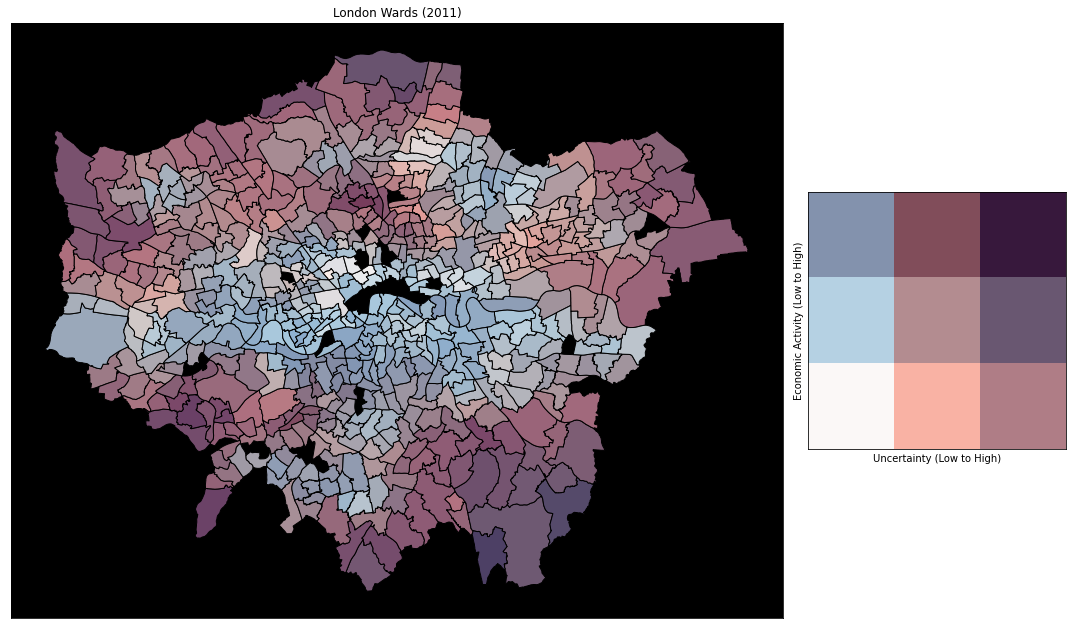

In [40]:
bivariate_plot(census_plot_df, "OA Percentage", "uncertainty", label_1="Economic Activity", label_2="Uncertainty")

In [16]:
def get_site_covs(model, df, codes):
    min_t, max_t = df["t"].min(), df["t"].max()
    # t_plot = np.linspace(min_t, max_t, max_t-min_t+1).reshape(-1, 1)
    t_plot = np.array([[0.]])
    
    scaled_lats, scaled_lons = [], []
    for code in codes:
        site_lat, site_lon = df.loc[df['code'] == code]['latitude'].unique()[0], df.loc[df['code'] == code]['longitude'].unique()[0]
        scaled_lat = scalers['latitude'].transform(np.array([[site_lat]])).item()
        scaled_lon = scalers['longitude'].transform(np.array([[site_lon]])).item()
        scaled_lats.append([scaled_lat])
        scaled_lons.append([scaled_lon])
    
    scaled_lats, scaled_lons = np.array(scaled_lats), np.array(scaled_lons)
    R_plot = np.tile(np.hstack((scaled_lats, scaled_lons)), [t_plot.shape[0], 1, 1])

    return model.predict(X=t_plot, R=R_plot)

def test_predict(model, df, codes):
    min_t, max_t = df["t"].min(), df["t"].max()
    # t_plot = np.linspace(min_t, max_t, max_t-min_t+1).reshape(-1, 1)
    t_plot = np.array([[0.]])
    
    scaled_lats, scaled_lons = [], []
    for code in codes:
        site_lat, site_lon = df.loc[df['code'] == code]['latitude'].unique()[0], df.loc[df['code'] == code]['longitude'].unique()[0]
        scaled_lat = scalers['latitude'].transform(np.array([[site_lat]])).item()
        scaled_lon = scalers['longitude'].transform(np.array([[site_lon]])).item()
        scaled_lats.append([scaled_lat])
        scaled_lons.append([scaled_lon])
    
    scaled_lats, scaled_lons = np.array(scaled_lats), np.array(scaled_lons)
    R_plot = np.tile(np.hstack((scaled_lats, scaled_lons)), [t_plot.shape[0], 1, 1])

    return model.predict_y(X=t_plot, R=R_plot)


In [17]:
df.head()

,code,date,nox,no2,latitude,longitude,t
14607,HK6,2011-01-01,125.979467,57.506791,51.526454,-0.084910,0
18872,KC2,2011-01-01,101.209239,54.483442,51.495504,-0.178809,0
18519,KC1,2011-01-01,38.743819,31.946076,51.521047,-0.213492,0
18179,IS6,2011-01-01,32.551769,28.877916,51.557895,-0.106989,0
28799,WA7,2011-01-01,277.631357,126.976950,51.463429,-0.215871,0


In [18]:
test_mean, test_cov = get_site_covs(model, df, ["HK6", "KC2", "KC1"])

In [20]:
true_mean, true_cov = test_predict(model, df, ["HK6", "KC2", "KC1"])

In [23]:
test_cov/true_cov

DeviceArray([0.31662968, 0.27139954, 0.44211957], dtype=float64)

In [15]:
def save_obj(filename, obj, obj_name):
    path = f"GPR-models/ST-SVGP/{filename}/"
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    fullpath = f"{path}{filename}_{obj_name}.sav"
    pickle.dump(obj, open(fullpath, "wb"))

In [16]:
def load_obj(filename, obj_name):
    path = f"GPR-models/ST-SVGP/{filename}/{filename}_{obj_name}.sav"
    return pickle.load(open(path, 'rb'))

In [189]:
save_obj(filename, census_plot_df, "census_df")